# 概述
包含数据清洗、特征工程、建模的整个流程可以看做是一个大的pipeline，而每个阶段又可以看做的一个state pipeline。

所谓的pipeline，形象的说明了这个过程，管道都是由一节一节的管子拼接起来的，这些管子可以自由拆卸和组装(有些管子有依赖，也就是说要装管子B，必须得先装好管子A)

要装哪些pipe，怎么装，这些都是会经常调整和改变的，特别是在前期特征工程的时候。所以，这些经常变的东西应该分离出来，做出配置项，方便管理和维护！

每个pipeline的一个点是pipe，

pipe之间可以是相互独立的(没有先后关系，意味着处理时可以并行)，还有一些是有依赖关系的(必须一个pipe跑完才能跑另外一个)

并行的stage: 如完全是不同方面的特征，如保单的特征和被保人的特征；

pipeline可以按照不同的阶段分组为多个stage pipeline

Data(raw data)

Tasks

Features

Models

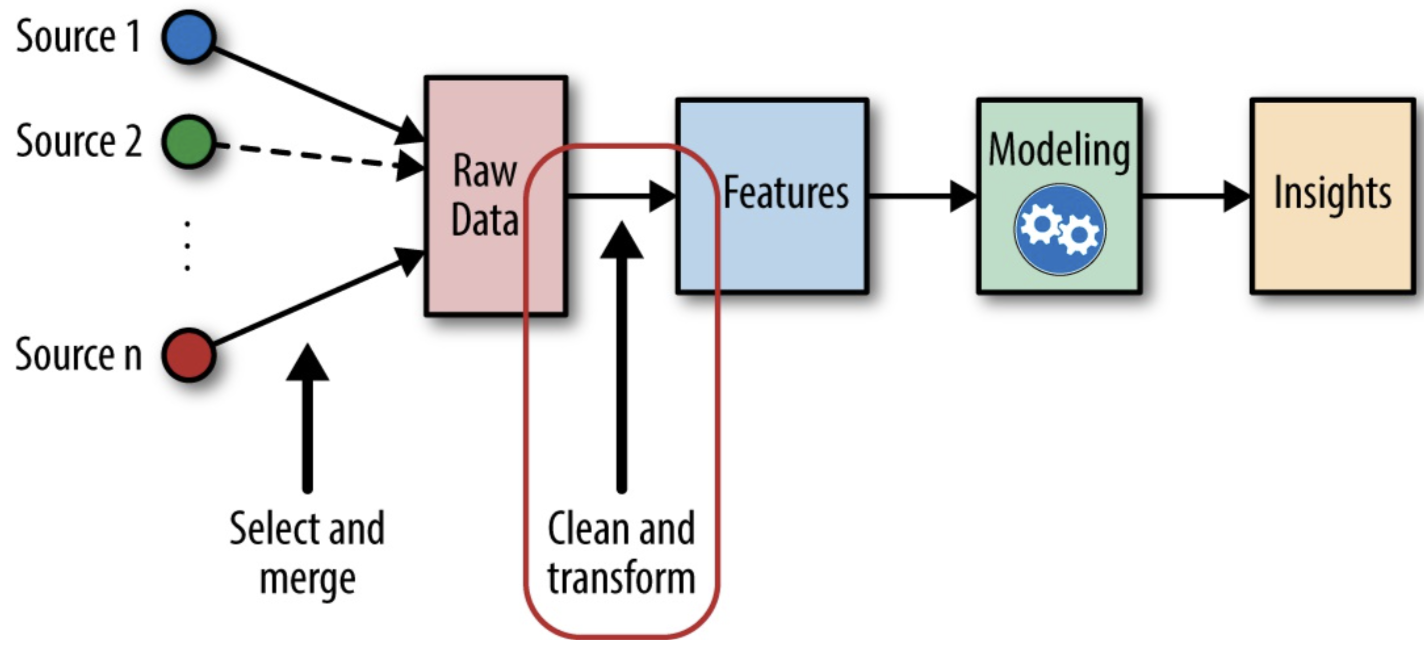

数据收集：从多个数据源收集数据，清洗(过滤，筛选)，形成大宽表DataFrame

数据探索：
* 区分num_col | cat_col | date_col, 
* date_col先粗略的算时间差,提取month|weekday|day  归入num_cols
* 观察num_col | cat_col总的分布情况及在各个label下的分布情况，

用默认的参数跑一组模型，选出效果最好的模型作为默认模型，作为baseline

特征工程：根据数据探索的结果和业务方面的知识，进行
* 缺失值|异常值处理
* 特征的构建（如时间方面的统计特征）

再去用默认的参数跑一下模型

特征筛选&模型调参
* 根据模型结果进行特征筛选(如树模型中，把不重要的特征筛掉)
* 在这个阶段要对哪些是重要特征，特征间的关系有一个全面系统的认识

一定要在每次调参后，观察模型结果是如何变化的，而不是简单看看评估指标有无提升；

这会对后续的模型集成有帮助，可以把有最互补的模型集成，这样效果会好

模型集成  
这里有几种集成方法
* 相同模型+不同特征  
一般对于现在模型本身已经是集成模型，如GBDT，这种方式会好！
* 不同模型+相同特征
* 不同模型+不同特征

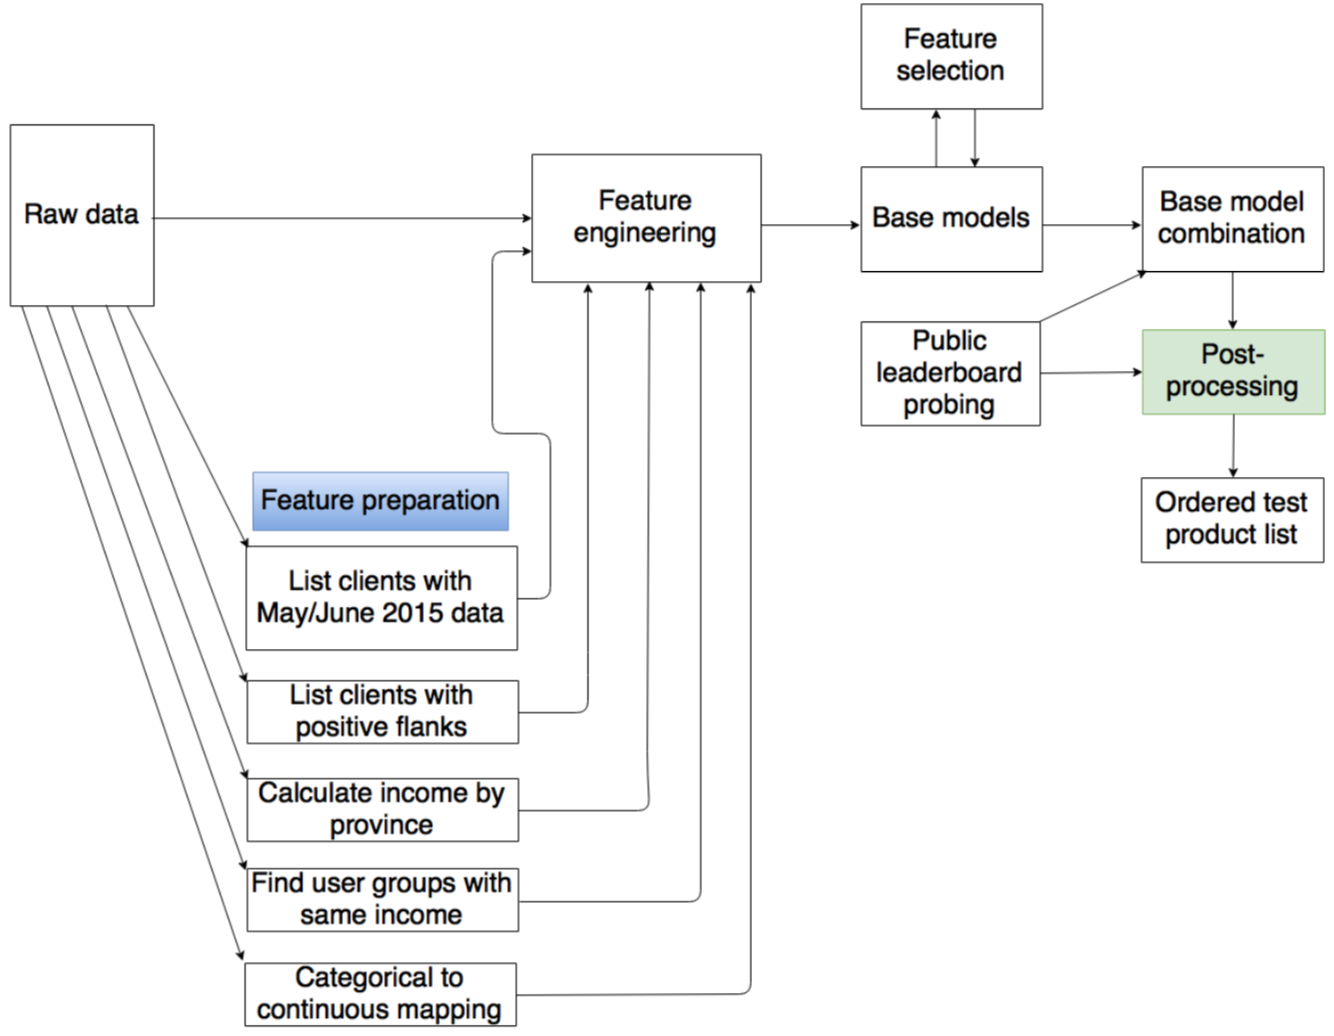

# 使用pdpipe与Pandas构建管道

可以参考pdpipe的做法和api，其实自己做也不会很难。 pipeline的主要工作和难点在于整合！

https://mp.weixin.qq.com/s/URsFRHDwApp3Oj3fwtxnwg

原文链接：
https://towardsdatascience.com/https-medium-com-tirthajyoti-build-pipelines-with-pandas-using-pdpipe-cade6128cd31

https://github.com/mayi140611/Machine-Learning-with-Python/blob/master/Pandas%20and%20Numpy/pdpipe-example.ipynb

Pandas 是 Python 生态系统中的一个了不起的库，用于数据分析和机器学习。它在 Excel/CSV 文件和 SQL 表所在的数据世界与 Scikit-learn 或 TensorFlow 施展魔力的建模世界之间架起了完美的桥梁。
 
数据科学流通常是一系列的步骤：数据集必须经过清理、缩放和验证，之后才能被强大的机器学习算法使用。
 
当然，这些任务可以通过 Pandas 等包提供的许多单步函数或方法来完成，但更为优雅的方式是使用管道。在几乎所有的情况下，通过自动执行重复性任务，管道可以减少出错的机会，并能够节省时间。

在数据科学领域中，具有管道特性的软件包有 R 语言的 dplyr 和 Python 生态系统中的 Scikit-learn。

对本文这个演示中显示的所有操作进行总结，则如下所示：
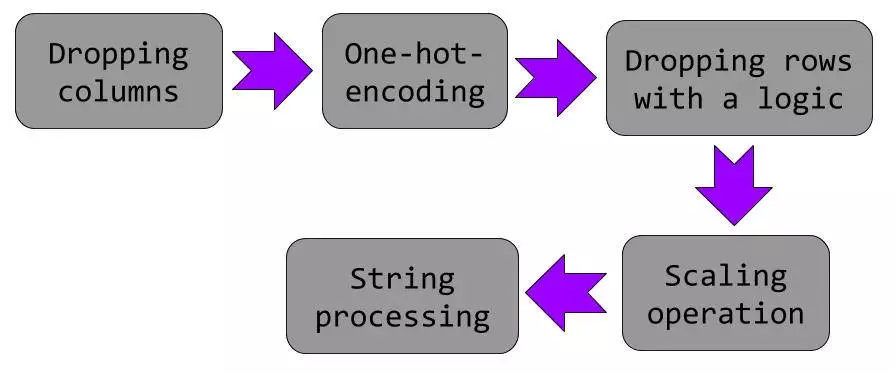
所有这些操作都可以在类似类型的数据集上频繁使用，并在数据集准备好进入下一级建模之前，能有一组简单的顺序代码块作为预处理操作来执行，将是非常棒的。
 
流水线是实现统一的顺序代码块集的关键。Pandas 是机器学习和数据科学团队中用于这类数据预处理任务的最广泛使用的 Python 库，而 pdpipe 则提供了一种简单而强大的方法，可以使用 Pandas 类型操作构建管道，可以直接应用于 Pandas DataFrame 对象。
 
你可以自己探索这个库，为你的特定数据科学任务构建更强大的管道。
 

In [3]:
# !pip install pdpipe
!pip freeze | grep pdpipe

pdpipe==0.0.38


In [4]:
import pandas as pd
import numpy as np
import pdpipe as pdp

In [5]:
df = pd.read_csv("data/USA_Housing.csv")

In [7]:
df.shape

(5000, 7)

In [8]:
df.sample(5)

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address
520,63185.836850,7.095153,6.824286,3.01,40080.690601,1.115013e+06,"025 Taylor Point\nNew Kayla, CO 57215-1414"
4043,68227.881569,6.108941,5.891688,3.06,38294.558895,1.038154e+06,"60062 Butler Isle Apt. 286\nChristopherland, H..."
1089,83729.791766,4.403197,5.213234,3.19,12906.254845,6.244330e+05,"914 Beasley Pines Suite 756\nLake Phillip, VA ..."
2259,73875.676009,4.934697,6.499534,2.09,34332.420963,9.158185e+05,"332 Cabrera Shoal Apt. 452\nNew John, WI 34660"
1746,65431.664761,4.401142,7.283061,4.00,38499.376932,9.635319e+05,"58828 Williams Rue Suite 120\nLake Sarahmouth,..."


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg. Area Income,5000.0,6.858311e+04,10657.991214,17796.631190,61480.562388,6.880429e+04,7.578334e+04,1.077017e+05
Avg. Area House Age,5000.0,5.977222e+00,0.991456,2.644304,5.322283,5.970429e+00,6.650808e+00,9.519088e+00
Avg. Area Number of Rooms,5000.0,6.987792e+00,1.005833,3.236194,6.299250,7.002902e+00,7.665871e+00,1.075959e+01
Avg. Area Number of Bedrooms,5000.0,3.981330e+00,1.234137,2.000000,3.140000,4.050000e+00,4.490000e+00,6.500000e+00
Area Population,5000.0,3.616352e+04,9925.650114,172.610686,29403.928702,3.619941e+04,4.286129e+04,6.962171e+04
Price,5000.0,1.232073e+06,353117.626581,15938.657923,997577.135049,1.232669e+06,1.471210e+06,2.469066e+06


In [11]:
def size(n):
    if n<=4:
        return 'Small'
    elif 4<n<=6:
        return 'Medium'
    else:
        return 'Big'

df['House_size']=df['Avg. Area Number of Rooms'].apply(size)

In [12]:
df.sample(2)

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address,House_size
3061,62311.387753,5.492310,5.690825,4.23,51601.594007,1.019128e+06,"59911 Anderson Corner\nHatfieldfurt, NY 23873",Medium
1906,87003.995761,5.225235,8.497164,4.32,24269.056760,1.552915e+06,"287 Lewis Run Suite 404\nBurnettfurt, OH 39485",Big


## 最简单的管道：一次操作
 
我们从最简单的管道开始，它只包含一次操作（不必担心，我们很快就会增加复杂性的）。
 
让我们假设机器学习团队和领域专家说他们认为我们可以安全地忽略用于建模的数据 `Avg. Area House Age` 。因此，我们将从数据集中删除这一列。
 
对于这个任务，我们使用 pdpipe 中的 `ColDrop` 来创建一个管道对象 `drop_age`，并将 DataFrame 传递给这个管道。

In [13]:
drop_age = pdp.ColDrop('Avg. Area House Age')

In [14]:
df2 = drop_age(df)

In [15]:
df2.sample(2)

,Avg. Area Income,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address,House_size
1115,70743.195507,5.220528,3.31,26897.712051,874969.696866,"7526 Kara Club Suite 242\nDeannabury, KY 79535",Medium
4589,61194.479591,7.091024,4.07,28667.140510,369433.354965,USNS Weaver\nFPO AE 62010,Big


## 只需添加管道链级
 
只有当我们能够进行多个阶段时，管道才是有用和实用的。在 pdpipe 中有多种方法可以实现这一点。但是，最简单、最直观的方法是使用 + 运算符。这就像手工连接管道一样！
 
比方说，除了删除 `age` 列之外，我们还希望对 `House size` 的列进行独热编码，以便可以轻松地在数据集上运行分类或回归算法。

In [16]:
pipeline = pdp.ColDrop('Avg. Area House Age')
pipeline+= pdp.OneHotEncode('House_size')

In [17]:
df3 = pipeline(df)

In [18]:
df3.sample(2)

,Avg. Area Income,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address,House_size_Medium,House_size_Small
4043,68227.881569,5.891688,3.06,38294.558895,1.038154e+06,"60062 Butler Isle Apt. 286\nChristopherland, H...",1,0
2412,72099.665390,6.466645,3.41,36902.145390,1.411054e+06,"636 Smith Greens\nAlexland, AK 05521",0,0


## 根据行值删除某些行
 
接下来，我们可能希望根据行值来删除它们。

具体来说，我们可能希望删除房价低于 25 万的所有数据。

我们有 `ApplybyCol` 的方法来讲删除用户蒂尼的函数应用到 DataFrame，还有一个方法 `ValDrop` 根据特定值来删除某些行。我们可以轻松地将这些方法链接到管道，以便能够有选择地删除行（我们仍在向现有的管道对象中添加内容，该对象已经完成了列删除和独热编码的其他工作）。

In [19]:
def price_tag(x):
    if x>250000:
        return 'keep'
    else:
        return 'drop'

In [20]:
pipeline = pdp.ColDrop('Avg. Area House Age')
pipeline+= pdp.OneHotEncode('House_size')
pipeline+=pdp.ApplyByCols('Price',price_tag,'Price_tag',drop=False)

In [21]:
df4 = pipeline(df)

In [26]:
df4.Price_tag.value_counts()

keep    4990
drop      10
Name: Price_tag, dtype: int64

In [27]:
df4.sample(2)

,Avg. Area Income,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Price_tag,Address,House_size_Medium,House_size_Small
3810,59930.156068,6.693149,4.28,44095.461560,1.320897e+06,keep,"21153 Wayne Hills Suite 053\nNorth Keith, FL 1...",0,0
1892,48963.296155,8.454207,5.26,35431.251538,8.826666e+05,keep,"3563 Todd Islands\nReyesview, PW 68088",0,0


In [28]:
pipeline = pdp.ColDrop('Avg. Area House Age')
pipeline+= pdp.OneHotEncode('House_size')
pipeline+=pdp.ApplyByCols('Price',price_tag,'Price_tag',drop=False)
pipeline+=pdp.ValDrop(['drop'],'Price_tag')
pipeline+= pdp.ColDrop('Price_tag')

In [29]:
df5 = pipeline(df)

In [30]:
df5.sample(2)

,Avg. Area Income,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address,House_size_Medium,House_size_Small
902,67110.334377,7.236402,6.10,31998.763251,1.370700e+06,"965 Wilson Ridges\nHolmesland, VT 81072",0,0
307,57853.330196,7.316551,4.36,47688.226598,1.285933e+06,"507 Dorsey Harbor Suite 445\nNorth Jacobbury, ...",0,0


### 最近版本更新：直接删除行！
该包的最新版本可以用 lambda 函数，仅用一行代码即可完成行的删除（满足给定的条件），如下所示：

In [32]:
pdp.RowDrop({'Price': lambda x: x <= 250000})

PdPipelineStage: Drop rows by conditions: {'Price': <function <lambda> at 0x122a0e730>}

## Scikit-learn 与 NLTK
 
还有许多更有用、更直观的 DataFrame 操作方法可用于 DataFrame 操作。但是，我们只是想说明，即使是 Scikit-learn 和 NLTK 包中的一些操作，也包含在 pdpipe 中，用于创建非常出色的管道。

### Scikit-learn scaling
建立机器学习模型最常见的任务之一是数据的缩放。Scikit-learn 提供了集中不同类型的缩放，例如，最小最大缩放，或者基于标准化的缩放（其中，数据集的平均值被减去，然后除以标准差）。
 
我们可以在管道中直接链接这些缩放操作。下面的代码段演示了这种用法：

In [33]:
pipeline_scale = pdp.Scale('StandardScaler',exclude_columns=['House_size_Medium','House_size_Small'])

In [34]:
df6 = pipeline_scale(df5)

In [35]:
df6.sample(2)

,Avg. Area Income,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address,House_size_Medium,House_size_Small
929,0.093038,-1.355540,0.046750,0.304757,-1.223020,02315 Franklin Crescent Suite 962\nNorth Peter...,1,0
266,-1.222864,1.934627,1.634186,0.277766,-0.095651,"3407 Preston Pine\nEast Mark, NY 86626-3319",0,0


本文中，我们应用了 Scikit-learn 包中的 `StandardScaler` 估算器来转换数据以进行聚类或神经网络拟合。我们可以选择性地排除那些无需缩放的列，就像我们在本文中对指示列 `House_size_Medium` 和 `House_size_Small` 所做的那样。

### NLTK 的词法分析器
 
我们注意到，DataFrame 中的 Address 字段现在几乎毫无用处。但是，如果我们可以从这些字符串中提取邮政编码或州名，它们可能对某种形式的可视化或机器学习任务有用。
 
为此，我们可以使用 Word Tokenizer（单词标记器）来实现这一目的。NTLK 是一个流行而强大的 Python 库，用于文本挖掘和自然语言处理，并提供了一系列的标记器方法。在本文示例中，我们客户使用一个这样的标记器来拆分 Address 字段中的文本，并从中提取州名。我们注意到，州名就是地址字符串中的倒数第二个单词。因此，下面的链式管道就可以帮我们完成这项工作：

In [37]:
pipeline_tokenize=pdp.TokenizeText('Address')

In [38]:
df7 = pipeline_tokenize(df6)

In [39]:
df7.sample(2)

,Avg. Area Income,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address,House_size_Medium,House_size_Small
3566,-0.627279,1.111725,0.127741,0.379725,-0.104289,"[93723, Lisa, Valleys, Calebberg, ,, NV, 95783...",0,0
2619,-0.322330,-1.365554,0.160138,-0.810461,-0.888431,"[86068, James, Groves, Apt, ., 998, Jonesborou...",1,0


In [40]:
def extract_state(token):
    return str(token[-2])

In [41]:
pipeline_state = pdp.ApplyByCols('Address',extract_state,result_columns='State')

In [42]:
df8=pipeline_state(df7)

In [43]:
df8.sample(2)

,Avg. Area Income,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,State,House_size_Medium,House_size_Small
1178,1.167353,-0.273123,-1.564985,-1.045110,0.243476,GU,0,0
3069,-3.121892,-0.966365,0.419311,2.366603,-0.446906,AP,0,0
